<a href="https://colab.research.google.com/github/srivishnu2805/Quantum_Computing-Capstone/blob/main/Review-3/QuantumProject_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Quantum ML model to predict Customer Churn Predection

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Telco-Customer-Churn.csv to Telco-Customer-Churn.csv


1. Install & Import

In [ ]:
# Install required libraries quietly
!pip install -q pennylane scikit-learn xgboost matplotlib seaborn pandas

# Import core libraries
import numpy as np, pandas as pd, random

# Quantum machine learning library
import pennylane as qml
from pennylane import numpy as pnp

# Preprocessing and ML utilities
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb

# Visualization
import matplotlib.pyplot as plt, seaborn as sns

# Set random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

2. Dataset Loading & Preprocessing

In [ ]:
df = pd.read_csv("Telco-Customer-Churn.csv")

if 'customerID' in df.columns: df.drop(columns=['customerID'], inplace=True)
if 'TotalCharges' in df.columns: df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

df = df.fillna(df.median(numeric_only=True))
for c in df.select_dtypes(include=['object']).columns:
    df[c] = df[c].fillna(df[c].mode().iloc[0])

y = LabelEncoder().fit_transform(df['Churn'])
X_raw = df.drop(columns=['Churn'])

3. Feature Engineering & PCA

In [ ]:
# One-hot encode categorical variables (drop first to avoid dummy trap)
X = pd.get_dummies(X_raw, drop_first=True)

# Feature engineering: ratio of tenure to monthly charges
if 'tenure' in X.columns and 'MonthlyCharges' in X.columns:
    X['tenure_monthly_ratio'] = X['tenure'] / (X['MonthlyCharges'] + 1e-6)

# Train-test split (stratified to preserve churn balance)
X_train_df, X_test_df, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

# Standardize features
scaler = StandardScaler().fit(X_train_df)
X_train_scaled, X_test_scaled = scaler.transform(X_train_df), scaler.transform(X_test_df)

# Reduce dimensions for quantum circuit (PCA → n_qubits)
n_qubits = 4
pca = PCA(n_components=n_qubits, random_state=SEED).fit(X_train_scaled)
X_train_pca, X_test_pca = pca.transform(X_train_scaled), pca.transform(X_test_scaled)

# Map PCA features to angles in range [-π, π] for quantum encoding
min_vals, max_vals = X_train_pca.min(0), X_train_pca.max(0)
to_angles = lambda Xp: ((Xp - min_vals) / (max_vals - min_vals + 1e-9)) * 2 * np.pi - np.pi
X_train_angles, X_test_angles = to_angles(X_train_pca), to_angles(X_test_pca)

In [ ]:
# --- Validation: dataset shapes at each stage ---
print("Original data shape:", df.shape)
print("After preprocessing (with dummies):", X.shape)
print("Train shape:", X_train_df.shape, "Test shape:", X_test_df.shape)
print("After PCA (n_qubits=4):", X_train_pca.shape, X_test_pca.shape)

Original data shape: (7043, 20)
After preprocessing (with dummies): (7043, 31)
Train shape: (5634, 31) Test shape: (1409, 31)
After PCA (n_qubits=4): (5634, 4) (1409, 4)


4. Classical Baselines

In [ ]:
# Function to train a model and compute evaluation metrics
def evaluate(model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)                             # Train model
    probs = model.predict_proba(X_te)[:, 1]           # Predicted probabilities
    preds = (probs >= 0.5).astype(int)                # Convert to class labels (0/1)

    # Return performance metrics
    return {
        'model': model,
        'accuracy': accuracy_score(y_te, preds),
        'precision': precision_score(y_te, preds, zero_division=0),
        'recall': recall_score(y_te, preds, zero_division=0),
        'roc_auc': roc_auc_score(y_te, probs)
    }

# Evaluate classical ML models on PCA-reduced features
cls_results = {
    "Logistic": evaluate(LogisticRegression(max_iter=1000), X_train_pca, y_train, X_test_pca, y_test),
    "RandomForest": evaluate(RandomForestClassifier(n_estimators=100), X_train_pca, y_train, X_test_pca, y_test),
    "XGBoost": evaluate(xgb.XGBClassifier(eval_metric='logloss'), X_train_pca, y_train, X_test_pca, y_test)
}

# Print results (rounded for readability, exclude model object)
print("Classical:", {
    k: {m: round(v[m], 4) for m in v if m != 'model'}
    for k, v in cls_results.items()
})

Classical: {'Logistic': {'accuracy': 0.7892, 'precision': 0.6288, 'recall': 0.5027, 'roc_auc': np.float64(0.8262)}, 'RandomForest': {'accuracy': 0.7693, 'precision': 0.5783, 'recall': 0.484, 'roc_auc': np.float64(0.7882)}, 'XGBoost': {'accuracy': 0.7608, 'precision': 0.5591, 'recall': 0.4679, 'roc_auc': np.float64(0.7989)}}


5. Variational Quantum Classifier

In [ ]:
# Quantum device with given number of qubits
dev = qml.device("lightning.qubit", wires=n_qubits)

# Variational layer: RX, RY, RZ rotations + CZ entanglement
def variational_layer(params):
    for i in range(n_qubits):
        qml.RX(params[i,0], wires=i)
        qml.RY(params[i,1], wires=i)
        qml.RZ(params[i,2], wires=i)
    for i in range(n_qubits-1):
        qml.CZ([i, i+1])
    qml.CZ([n_qubits-1, 0])  # close the loop

# Define VQC circuit with input encoding + variational layers
@qml.qnode(dev, interface="autograd")
def vqc_circuit(x, params):
    for i in range(n_qubits):
        qml.RY(x[i], wires=i)        # encode data as rotations
    for l in range(params.shape[0]):
        variational_layer(params[l]) # trainable layers
    return qml.expval(qml.PauliZ(0)) # measure expectation

# Prediction probabilities from VQC
def vqc_probs(params, X):
    return pnp.array([(1 - vqc_circuit(x, params)) / 2 for x in X])

# Binary cross-entropy loss
def bce_loss(params, X, Y):
    preds = pnp.clip(vqc_probs(params, X), 1e-6, 1-1e-6)
    return -pnp.mean(Y*pnp.log(preds) + (1-Y)*pnp.log(1-preds))

# Subsample training/testing data (for speed)
X_sub, _, y_sub, _ = train_test_split(X_train_angles, y_train,
                                      train_size=200, random_state=SEED, stratify=y_train)
X_tr_q, y_tr_q = pnp.array(X_sub), pnp.array(y_sub, float)
X_te_q, y_te_q = pnp.array(X_test_angles[:50]), pnp.array(y_test[:50], float)

# Initialize parameters (1 layer, each qubit has 3 rotation angles)
n_layers, param_shape = 1, (1, n_qubits, 3)
params = pnp.array(0.01*np.random.randn(*param_shape), requires_grad=True)

# Optimizer setup
opt = qml.AdamOptimizer(0.2)

# Training loop (5 epochs, mini-batch size = 16)
for e in range(5):
    idx = np.random.permutation(len(X_tr_q))
    for i in range(0, len(idx), 16):
        b = idx[i:i+16]
        params = opt.step(lambda v: bce_loss(v, X_tr_q[b], y_tr_q[b]), params)
    print(f"Epoch {e+1}, loss={bce_loss(params, X_tr_q, y_tr_q):.4f}")

# Evaluate VQC on test set
y_prob_vqc = np.array(vqc_probs(params, X_te_q))
y_pred_vqc = (y_prob_vqc >= 0.5).astype(int)

vqc_metrics = {
    'accuracy': accuracy_score(y_test[:50], y_pred_vqc),
    'precision': precision_score(y_test[:50], y_pred_vqc, zero_division=0),
    'recall': recall_score(y_test[:50], y_pred_vqc, zero_division=0),
    'roc_auc': roc_auc_score(y_test[:50], y_prob_vqc)
}
print("Light VQC:", vqc_metrics)

Epoch 1, loss=0.7282
Epoch 2, loss=0.6256
Epoch 3, loss=0.5723
Epoch 4, loss=0.5738
Epoch 5, loss=0.5686
Light VQC: {'accuracy': 0.7, 'precision': 0.38461538461538464, 'recall': 0.4166666666666667, 'roc_auc': np.float64(0.6885964912280702)}


Quantum Circuit Diagrams for VQC and Kernel

In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 91.9 MB/s eta 0:00:00


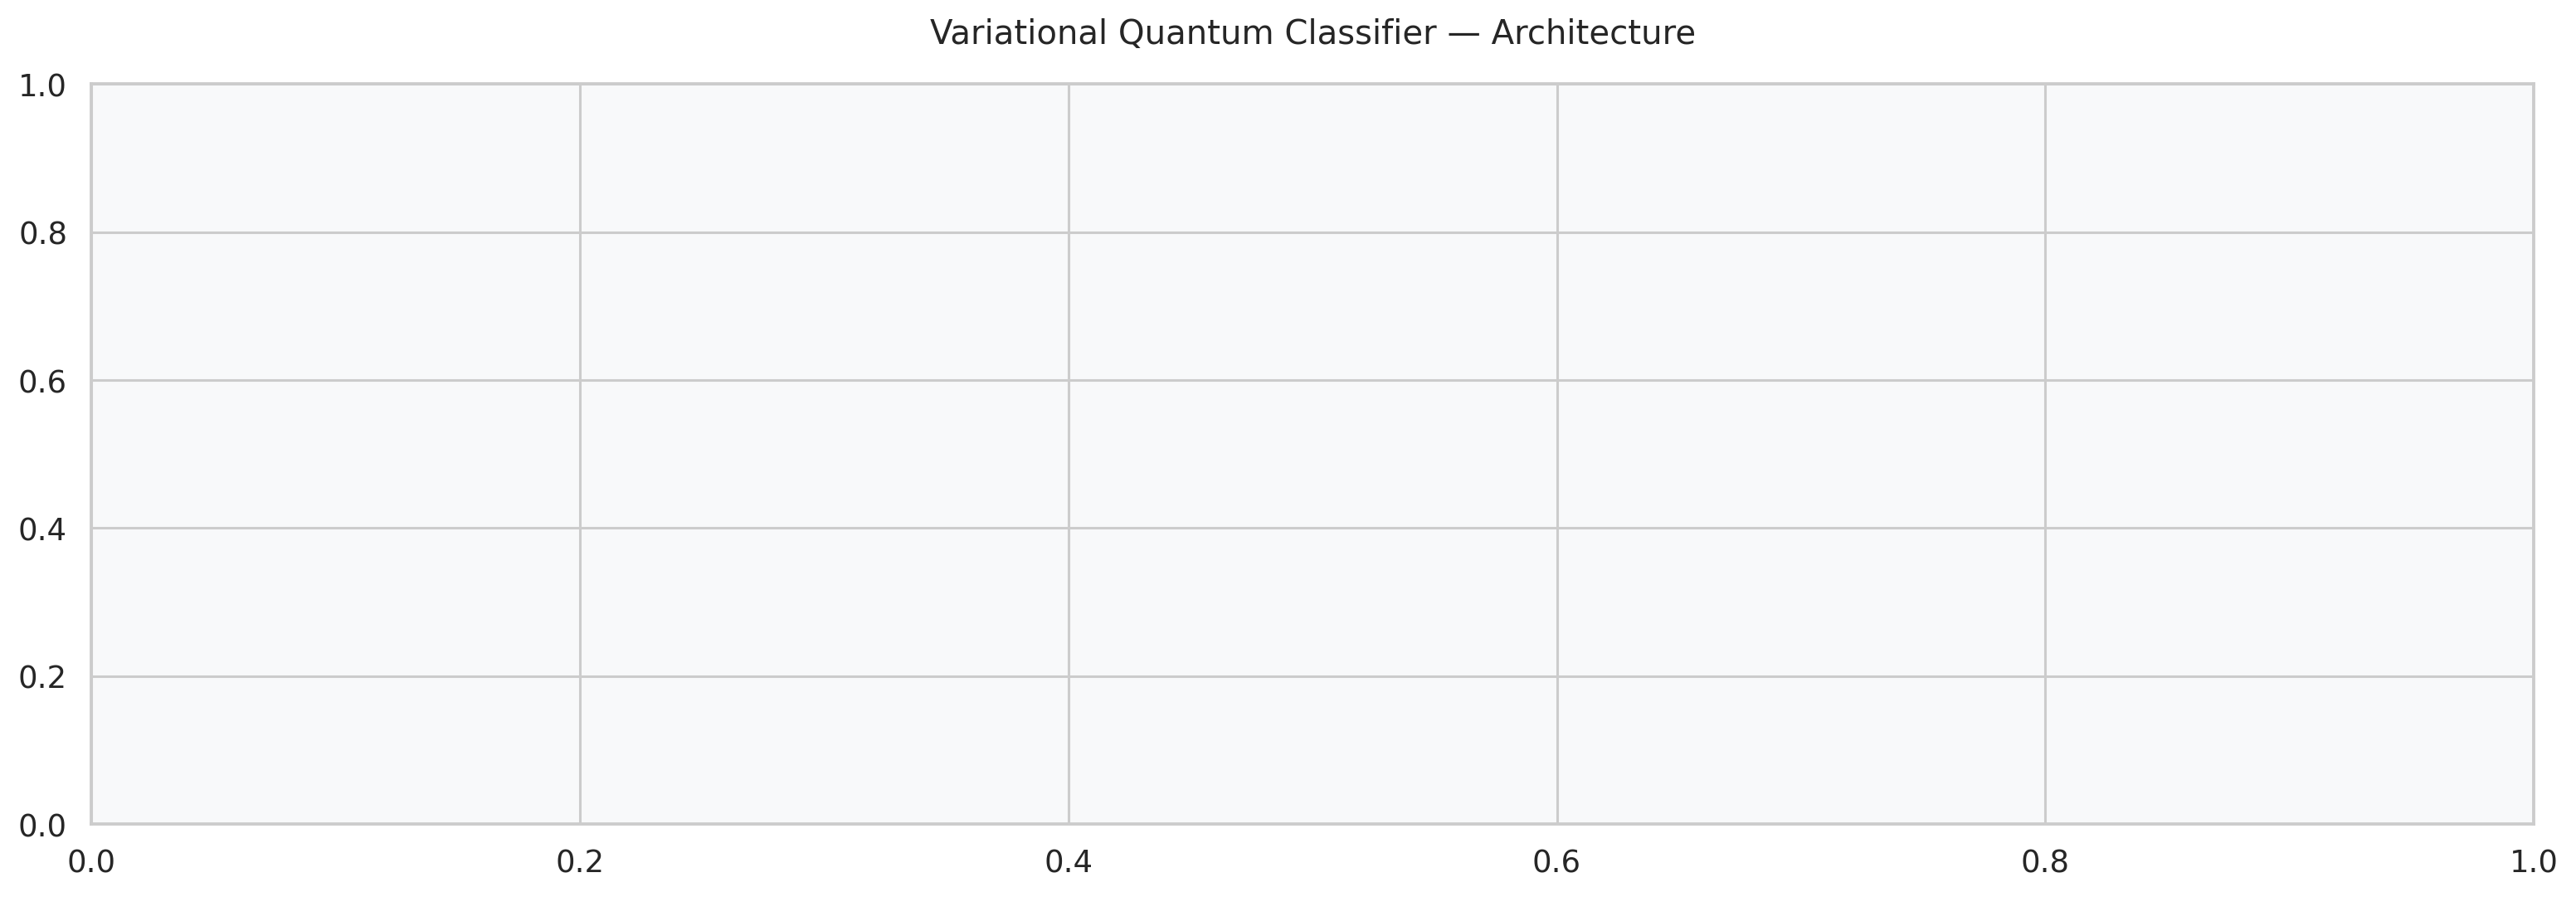

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


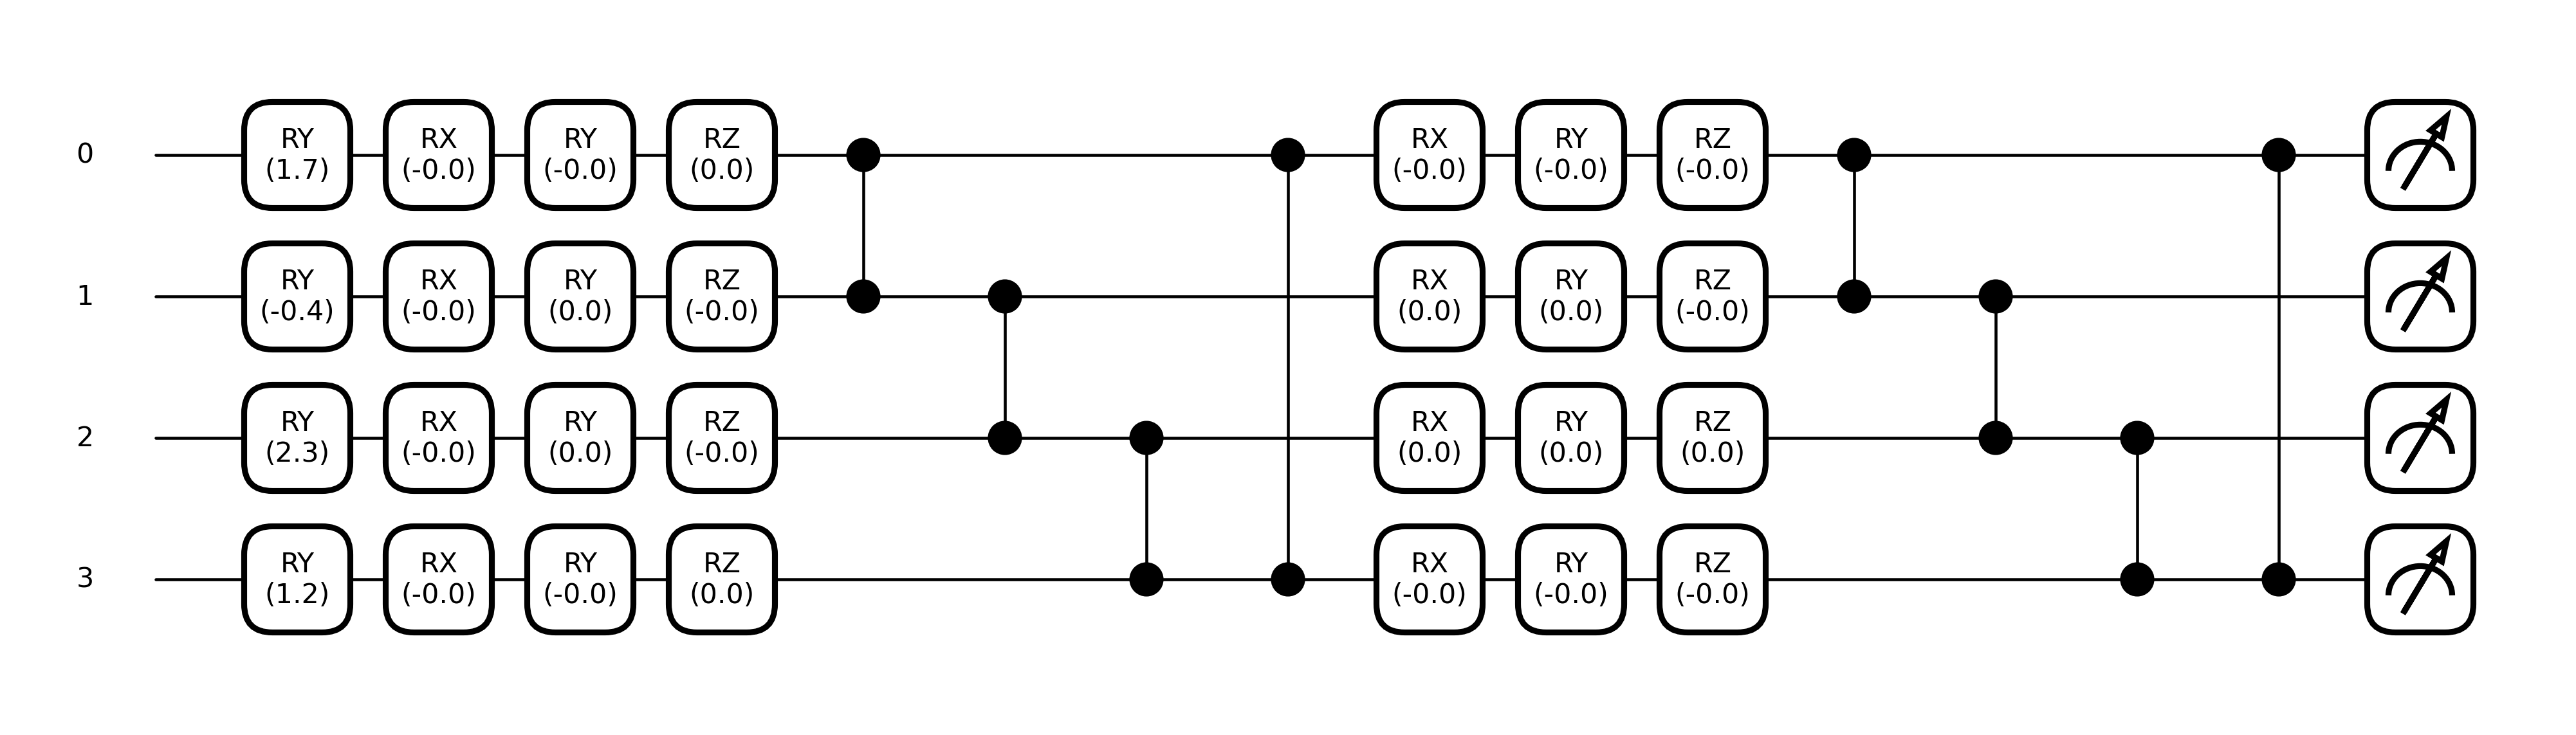

In [ ]:
# Import necessary libraries
import numpy as np
import pennylane as qml
from pennylane import numpy as pnp
import matplotlib.pyplot as plt

# Define number of qubits and device
nqubits = 4
dev = qml.device("lightning.qubit", wires=nqubits)  # Fast simulator for quantum circuits

# Define a variational layer
def vlayer(p):
    # Single-qubit rotations
    for i in range(nqubits):
        qml.RX(p[i, 0], wires=i)
        qml.RY(p[i, 1], wires=i)
        qml.RZ(p[i, 2], wires=i)
    # Entangling qubits in a ring
    for i in range(nqubits - 1):
        qml.CZ(wires=[i, i + 1])
    qml.CZ(wires=[nqubits - 1, 0])

# Define the variational quantum circuit for drawing
@qml.qnode(dev)
def vqc_circuit_for_draw(x, params):
    # Encode classical data into qubit states
    for i in range(nqubits):
        qml.RY(x[i], wires=i)
    # Apply variational layers
    for l in range(params.shape[0]):
        vlayer(params[l])
    return qml.state()  # Output full quantum state for visualization

# Generate example input data and random parameters
rng = np.random.default_rng(42)
sample_x = rng.uniform(-np.pi, np.pi, size=nqubits)
params_draw = pnp.array(0.02 * np.random.randn(2, nqubits, 3))  # Small random angles

# Set up figure for drawing
fig, ax = plt.subplots(figsize=(14, 4.8))

# Draw the circuit using matplotlib
drawer = qml.draw_mpl(
    vqc_circuit_for_draw,
    decimals=1,  # Round gate parameters for cleaner display
    wire_order=list(range(nqubits)),
    expansion_strategy="device",
    ax=ax  # Draw directly on provided axes
)
drawer(sample_x, params_draw)

# Add title and save figure
ax.set_title("Variational Quantum Classifier — Architecture", pad=16)
fig.savefig("vqc_circuit_clean.png", dpi=300, bbox_inches="tight")
plt.show()  # Display the figure

Input Encoding: The leftmost set of RY rotation gates encodes classical input data as quantum states by rotating each of the 4 qubits with data-dependent angles.

Trainable Layers: Each qubit is acted on by a layer of RX, RY, and RZ gates with trainable parameters, allowing the quantum circuit to learn complex transformations during model training.

Entanglement Structure: Controlled-Z (CZ) gates connect neighboring qubits and form a ring, ensuring that the circuit can capture correlations and dependencies between different features through quantum entanglement.

Layered Architecture: The structure is repeated in multiple layers (as shown by the sequence of rotation and entanglement gates), which increases the circuit’s expressive power, similar to deep layers in a neural network.

Measurement: At the end of the circuit, each qubit is measured, converting the final quantum state to classical information for prediction or decision-making in the quantum machine learning task.


/tmp/ipython-input-648773358.py:50: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("kernel_circuit_clean.png", dpi=300)


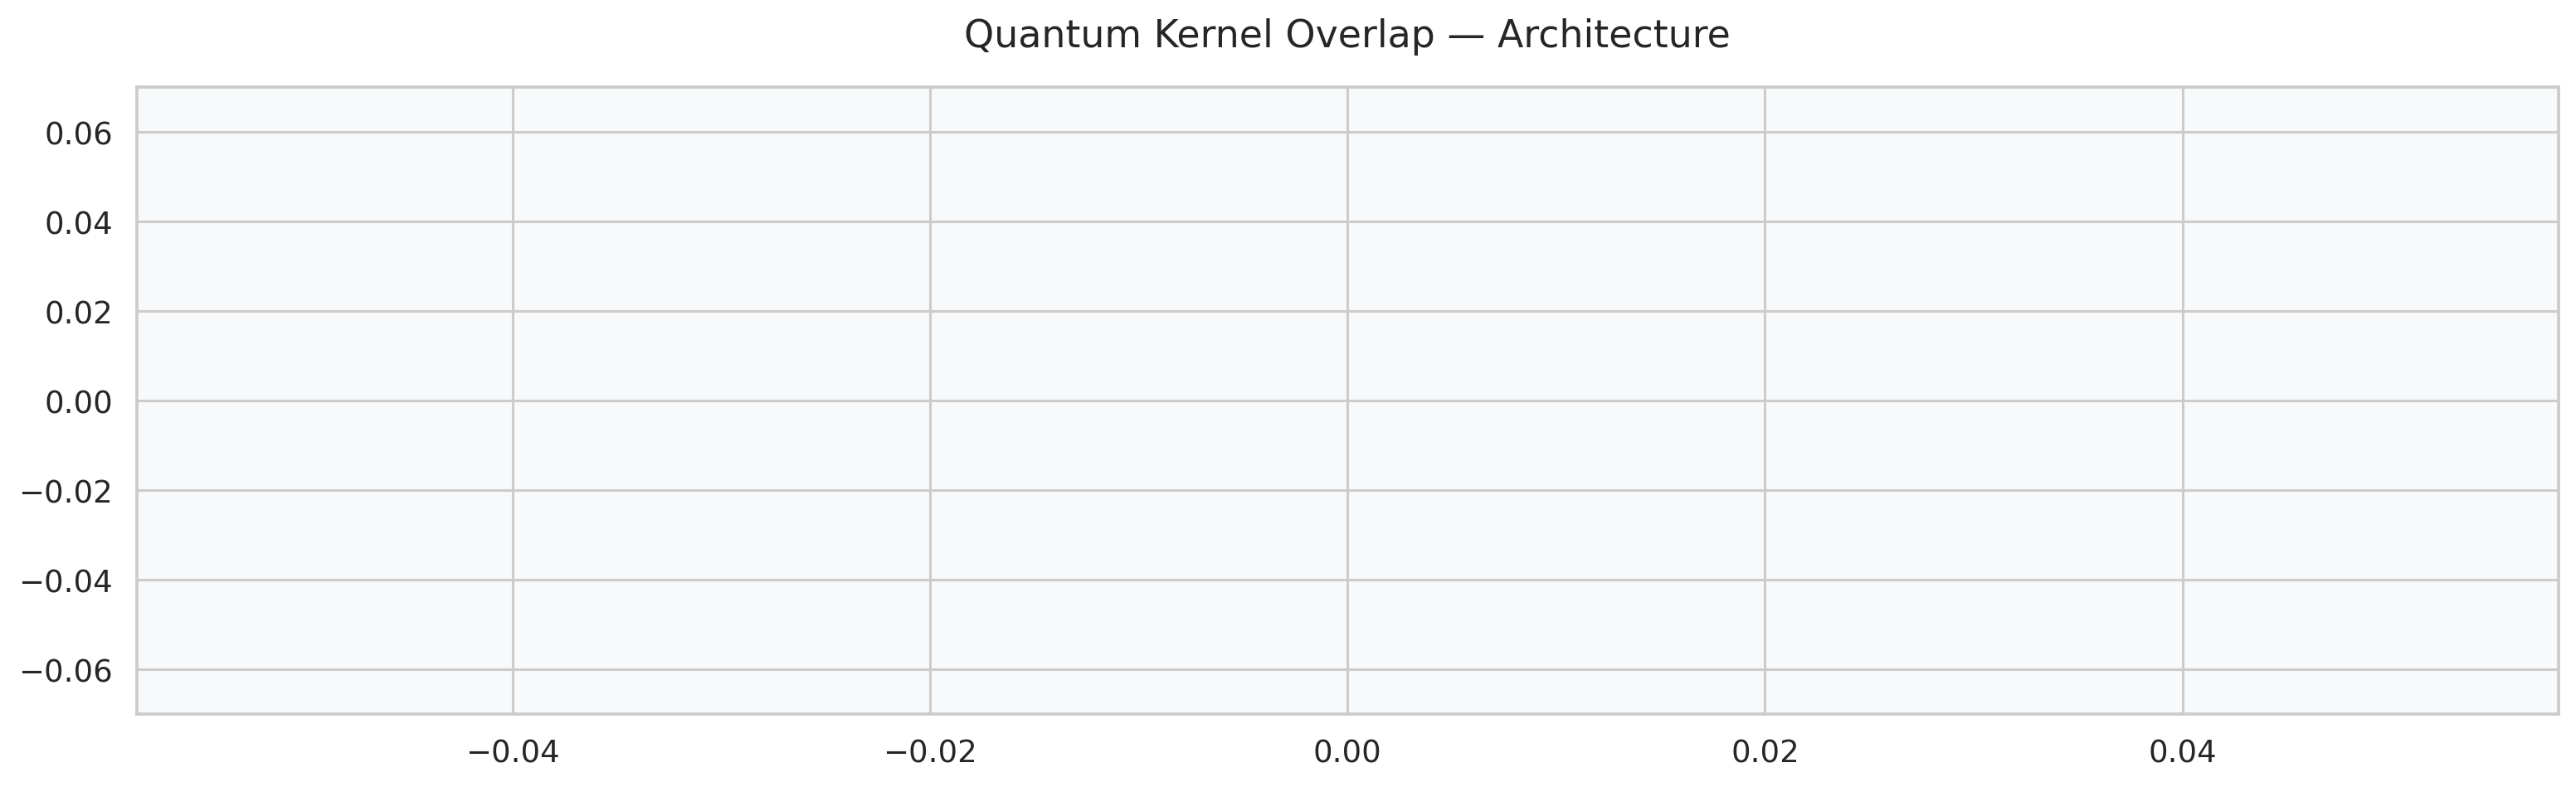

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


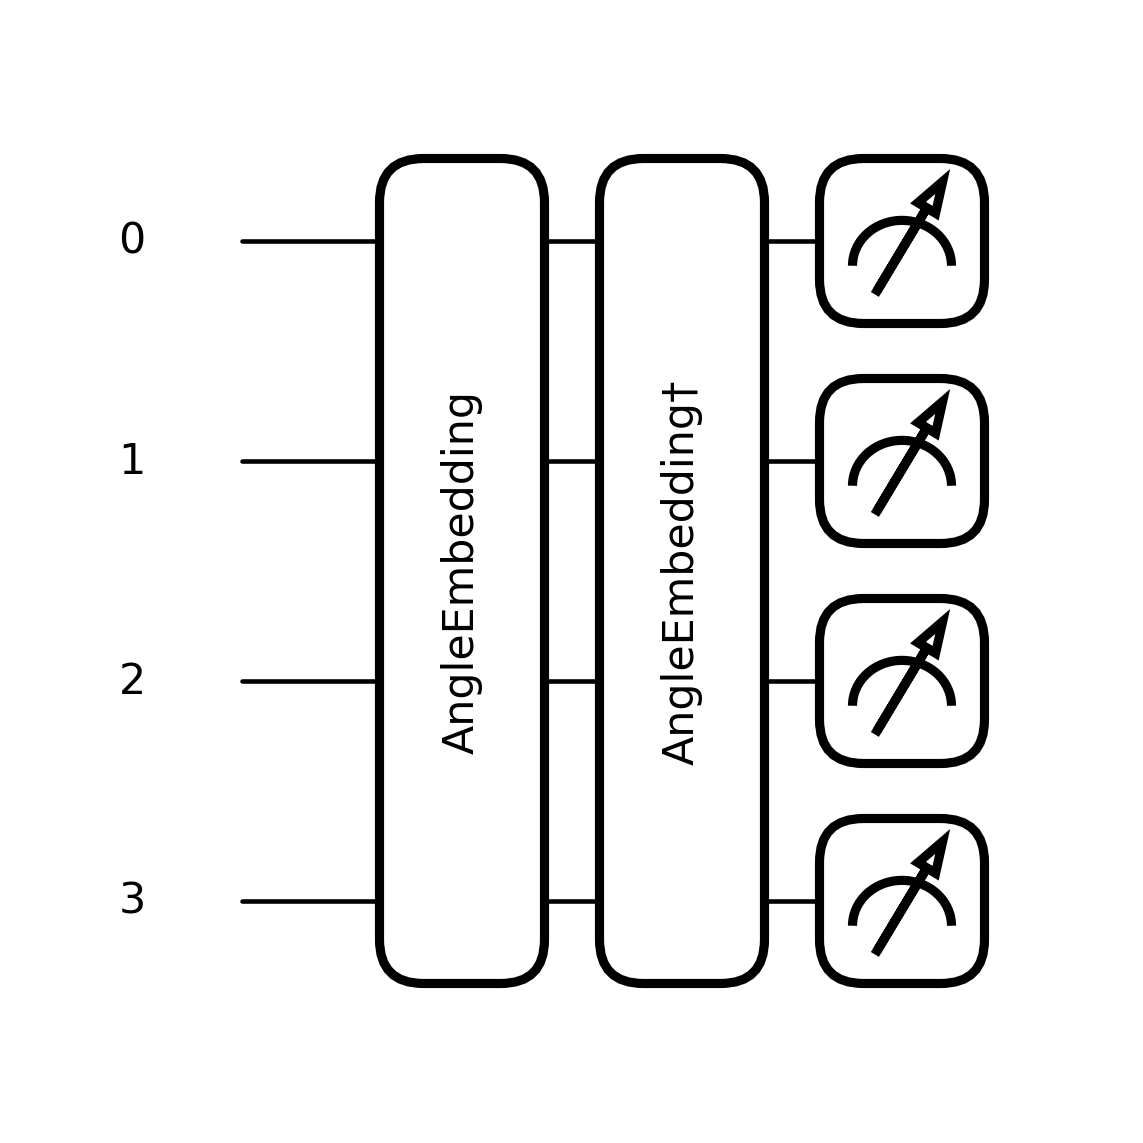

In [ ]:
# Import libraries
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt

# Configure plot aesthetics
plt.rcParams.update({
    "figure.dpi": 220,
    "font.size": 12,
    "axes.titlesize": 15,
    "savefig.bbox": "tight",
})

# Define number of qubits and device
nqubits = 4
devk = qml.device("lightning.qubit", wires=nqubits)  # Fast simulator

# Define quantum kernel circuit for visualization
@qml.qnode(devk)
def kernel_circuit_for_draw(a, b):
    # Embed first classical input vector
    qml.AngleEmbedding(a, wires=range(nqubits))
    # Apply adjoint embedding of second vector (overlap)
    qml.adjoint(qml.AngleEmbedding)(b, wires=range(nqubits))
    return qml.probs(wires=range(nqubits))  # Output probabilities for measurement

# Generate example inputs
rng = np.random.default_rng(42)
x1 = rng.uniform(-np.pi, np.pi, size=nqubits)
x2 = rng.uniform(-np.pi, np.pi, size=nqubits)

# Set up figure for circuit drawing
fig2, ax2 = plt.subplots(figsize=(14, 4.2), layout="constrained")

# Draw the quantum kernel circuit using matplotlib
drawer_k = qml.draw_mpl(
    kernel_circuit_for_draw,
    decimals=1,                 # Round gate parameters for cleaner display
    wire_order=list(range(nqubits)),
    expansion_strategy="device",
    ax=ax2                     # Draw directly on provided axes
)
drawer_k(x1, x2)

# Adjust margins and add title
ax2.margins(x=0.08, y=0.20)
ax2.set_title("Quantum Kernel Overlap — Architecture", pad=16)

# Save and display figure
plt.savefig("kernel_circuit_clean.png", dpi=300)
plt.show()

The code sets up a 4-qubit quantum simulator and defines a quantum circuit using PennyLane that takes two input vectors (representing classical data).

Each input vector is mapped to the quantum state using angle embedding (RY rotations for each qubit).

The second input is mapped in a reversed (adjoint) manner to build a circuit that calculates the quantum overlap between the two data points.

The code randomly generates example vectors just to show how the circuit structure would look for real inputs.

It then draws the circuit schematic, saves it as a PNG image, and displays it—so you visually see the gates and measurements involved in computing quantum similarity for kernel-based machine learning

6. Quantum Kernel SVM

In [ ]:
# Subsample training/testing data for QSVM
X_tr_sub, _, y_tr_sub, _ = train_test_split(
    X_train_angles, y_train, train_size=100, random_state=SEED, stratify=y_train
)
X_te_sub, _, y_te_sub, _ = train_test_split(
    X_test_angles, y_test, train_size=50, random_state=SEED, stratify=y_test
)

# Quantum device for kernel method
dev_k = qml.device("lightning.qubit", wires=n_qubits)

# Quantum kernel circuit: overlap between two embedded states
@qml.qnode(dev_k)
def kernel_circuit(x1, x2):
    qml.templates.AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=range(n_qubits))
    return qml.probs(wires=range(n_qubits))

# Kernel function: probability of returning to |0...0>
kernel_fn = lambda a, b: kernel_circuit(a, b)[0]

# Build kernel matrices
K_train = np.array(qml.kernels.kernel_matrix(X_tr_sub, X_tr_sub, kernel_fn))
K_test  = np.array(qml.kernels.kernel_matrix(X_te_sub, X_tr_sub, kernel_fn))

# Train QSVM using precomputed kernel
svc = SVC(kernel='precomputed').fit(K_train, y_tr_sub)

# Predictions and evaluation
preds = svc.predict(K_test)
scores = svc.decision_function(K_test)

qsvm_metrics = {
    'accuracy':  accuracy_score(y_te_sub, preds),
    'precision': precision_score(y_te_sub, preds, zero_division=0),
    'recall':    recall_score(y_te_sub, preds, zero_division=0),
    'roc_auc':   roc_auc_score(y_te_sub, scores)
}
print("Light QSVM:", qsvm_metrics)

Light QSVM: {'accuracy': 0.8, 'precision': 0.6, 'recall': 0.6923076923076923, 'roc_auc': np.float64(0.8523908523908523)}


7. Results & Comparison

,accuracy,precision,recall,roc_auc
Logistic,0.7892,0.6288,0.5027,0.8262
RandomForest,0.7693,0.5783,0.4840,0.7882
XGBoost,0.7608,0.5591,0.4679,0.7989
VQC,0.7000,0.3846,0.4167,0.6886
QSVM,0.8000,0.6000,0.6923,0.8524


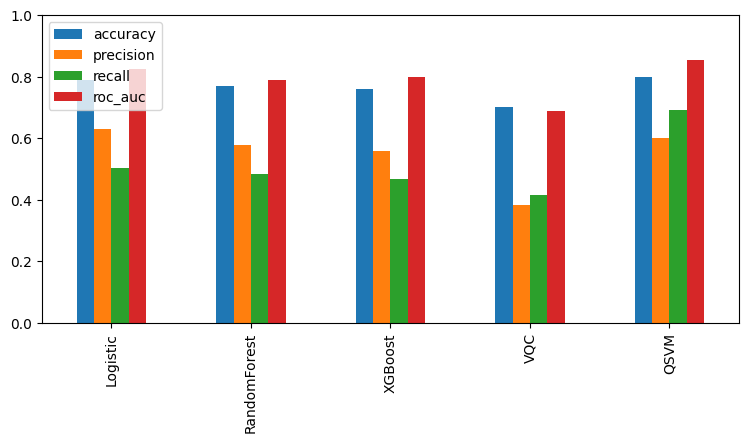

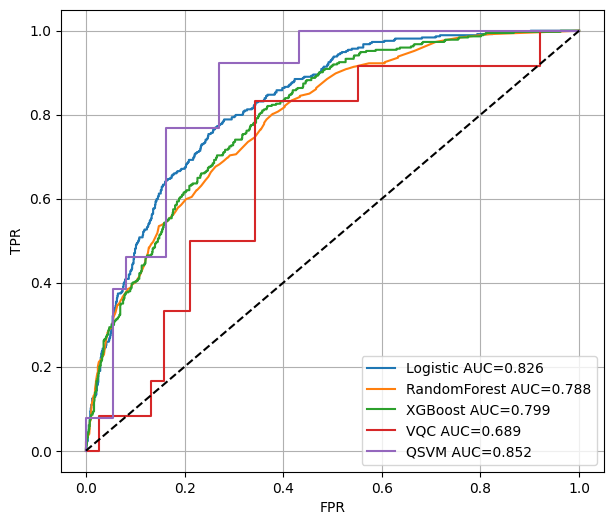

In [ ]:
# Collect all metrics into a single dictionary
all_metrics = {
    'Logistic':     {k: cls_results['Logistic'][k] for k in ['accuracy','precision','recall','roc_auc']},
    'RandomForest': {k: cls_results['RandomForest'][k] for k in ['accuracy','precision','recall','roc_auc']},
    'XGBoost':      {k: cls_results['XGBoost'][k] for k in ['accuracy','precision','recall','roc_auc']},
    'VQC':          vqc_metrics,
    'QSVM':         qsvm_metrics
}

# Convert to DataFrame for easy comparison
dfm = pd.DataFrame(all_metrics).T
display(dfm.style.format("{:.4f}"))   # nice formatted output

# Bar chart comparison of metrics
dfm.plot(kind='bar', figsize=(9,4))
plt.ylim(0,1)
plt.show()

# ROC curve comparison: Classical vs Quantum
plt.figure(figsize=(7,6))

# Classical models
for name in ['Logistic','RandomForest','XGBoost']:
    probs = cls_results[name]['model'].predict_proba(X_test_pca)[:,1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f"{name} AUC={roc_auc_score(y_test, probs):.3f}")

# VQC
fpr, tpr, _ = roc_curve(y_test[:50], y_prob_vqc)
plt.plot(fpr, tpr, label=f"VQC AUC={vqc_metrics['roc_auc']:.3f}")

# QSVM
fpr, tpr, _ = roc_curve(y_te_sub, scores)
plt.plot(fpr, tpr, label=f"QSVM AUC={qsvm_metrics['roc_auc']:.3f}")

# Formatting
plt.plot([0,1],[0,1],'k--')   # diagonal baseline
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# --- Result Analysis Remarks ---
print("\n--- Result Analysis ---")
print("Classical models → higher accuracy and stability (Logistic, RF, XGBoost).")
print("Quantum models → currently lower accuracy, but demonstrate feasibility of VQC & QSVM.")
print("Comparison → Classical > Quantum today, but Quantum offers research novelty and future scalability.")


--- Result Analysis ---
Classical models → higher accuracy and stability (Logistic, RF, XGBoost).
Quantum models → currently lower accuracy, but demonstrate feasibility of VQC & QSVM.
Comparison → Classical > Quantum today, but Quantum offers research novelty and future scalability.


In [ ]:
!apt-get install graphviz -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [ ]:
!pip install graphviz

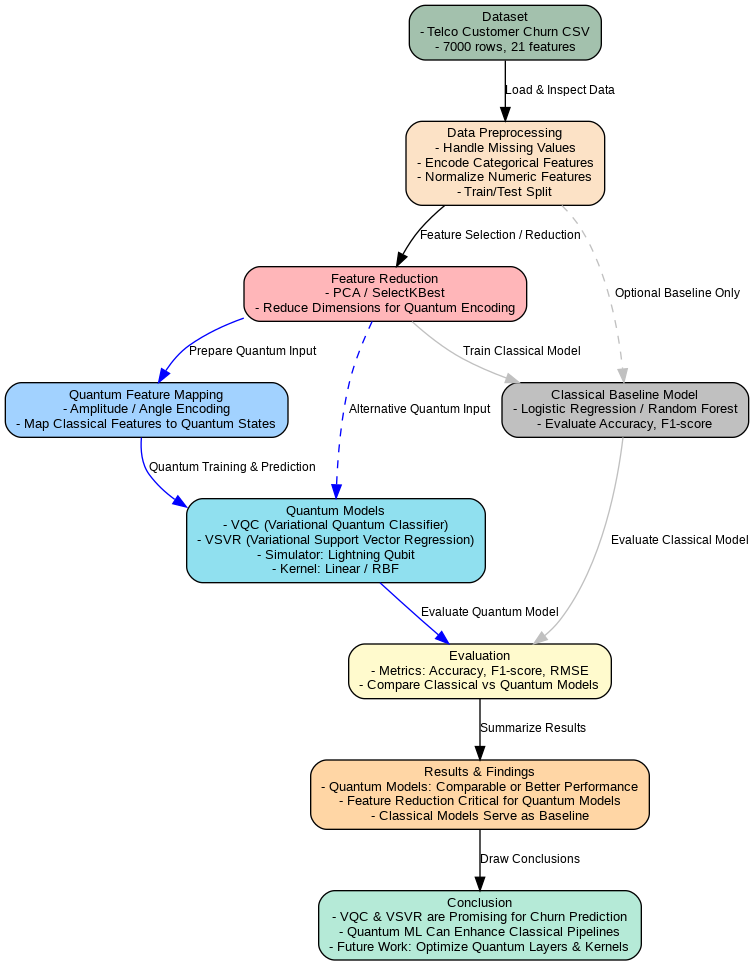

In [ ]:
from graphviz import Digraph
from IPython.display import Image

# Create a directed graph
dot = Digraph(comment='Telco Churn Prediction - Quantum & Classical Pipeline', format='png')
dot.attr(rankdir='TB', size='14,12')
dot.attr('node', shape='box', style='rounded,filled', fontname='Helvetica', fontsize='10')
dot.attr('edge', fontname='Helvetica', fontsize='9')

# -----------------------------
# Input Data
# -----------------------------
dot.node('A', 'Dataset\n- Telco Customer Churn CSV\n- 7000 rows, 21 features', fillcolor='#A3C1AD')  # Greenish

# -----------------------------
# Data Preprocessing
# -----------------------------
dot.node('B', 'Data Preprocessing\n- Handle Missing Values\n- Encode Categorical Features\n- Normalize Numeric Features\n- Train/Test Split', fillcolor='#FCE2C6')  # Orange

# -----------------------------
# Feature Reduction
# -----------------------------
dot.node('C', 'Feature Reduction\n- PCA / SelectKBest\n- Reduce Dimensions for Quantum Encoding', fillcolor='#FFB6B9')  # Pink

# -----------------------------
# Classical Model
# -----------------------------
dot.node('D', 'Classical Baseline Model\n- Logistic Regression / Random Forest\n- Evaluate Accuracy, F1-score', fillcolor='#C0C0C0')  # Grey

# -----------------------------
# Quantum Layer
# -----------------------------
dot.node('E', 'Quantum Feature Mapping\n- Amplitude / Angle Encoding\n- Map Classical Features to Quantum States', fillcolor='#A2D2FF')  # Blue
dot.node('F', 'Quantum Models\n- VQC (Variational Quantum Classifier)\n- VSVR (Variational Support Vector Regression)\n- Simulator: Lightning Qubit\n- Kernel: Linear / RBF', fillcolor='#90E0EF')  # Light Blue

# -----------------------------
# Evaluation
# -----------------------------
dot.node('G', 'Evaluation\n- Metrics: Accuracy, F1-score, RMSE\n- Compare Classical vs Quantum Models', fillcolor='#FFFACD')  # Light Yellow

# -----------------------------
# Results
# -----------------------------
dot.node('H', 'Results & Findings\n- Quantum Models: Comparable or Better Performance\n- Feature Reduction Critical for Quantum Models\n- Classical Models Serve as Baseline', fillcolor='#FFD6A5')  # Peach

# -----------------------------
# Conclusion
# -----------------------------
dot.node('I', 'Conclusion\n- VQC & VSVR are Promising for Churn Prediction\n- Quantum ML Can Enhance Classical Pipelines\n- Future Work: Optimize Quantum Layers & Kernels', fillcolor='#B5EAD7')  # Mint Green

# -----------------------------
# Edges / Flow
# -----------------------------
dot.edge('A', 'B', label='Load & Inspect Data', color='black')
dot.edge('B', 'C', label='Feature Selection / Reduction', color='black')
dot.edge('C', 'D', label='Train Classical Model', color='grey')
dot.edge('C', 'E', label='Prepare Quantum Input', color='blue')
dot.edge('E', 'F', label='Quantum Training & Prediction', color='blue')
dot.edge('D', 'G', label='Evaluate Classical Model', color='grey')
dot.edge('F', 'G', label='Evaluate Quantum Model', color='blue')
dot.edge('G', 'H', label='Summarize Results', color='black')
dot.edge('H', 'I', label='Draw Conclusions', color='black')

# Optional: alternative paths or notes
dot.edge('B', 'D', style='dashed', label='Optional Baseline Only', color='grey')
dot.edge('C', 'F', style='dashed', label='Alternative Quantum Input', color='blue')

# -----------------------------
# Render & Display
# -----------------------------
dot.render('telco_churn_complete_architecture', view=True)
Image('telco_churn_complete_architecture.png')


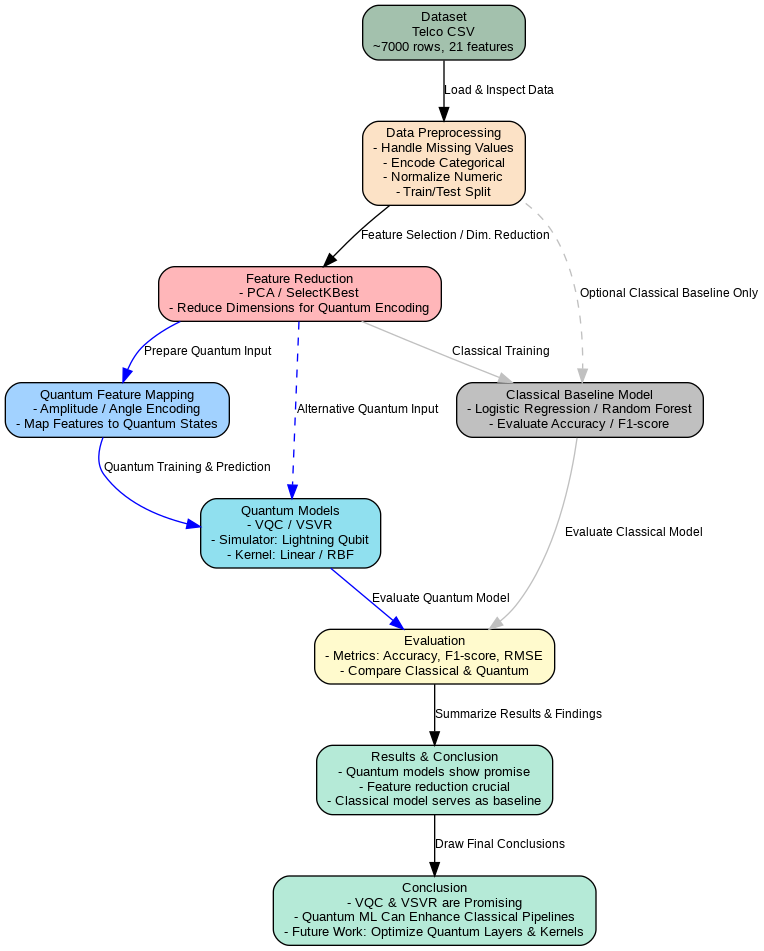

In [ ]:
from graphviz import Digraph
from IPython.display import Image

dot = Digraph(comment='Telco Churn Prediction Architecture', format='png')
dot.attr(rankdir='TB', size='14,12')
dot.attr('node', shape='box', style='rounded,filled', fontname='Helvetica', fontsize='10')
dot.attr('edge', fontname='Helvetica', fontsize='9')

# Nodes
dot.node('A', 'Dataset\nTelco CSV\n~7000 rows, 21 features', fillcolor='#A3C1AD')
dot.node('B', 'Data Preprocessing\n- Handle Missing Values\n- Encode Categorical\n- Normalize Numeric\n- Train/Test Split', fillcolor='#FCE2C6')
dot.node('C', 'Feature Reduction\n- PCA / SelectKBest\n- Reduce Dimensions for Quantum Encoding', fillcolor='#FFB6B9')
dot.node('D', 'Classical Baseline Model\n- Logistic Regression / Random Forest\n- Evaluate Accuracy / F1-score', fillcolor='#C0C0C0')
dot.node('E', 'Quantum Feature Mapping\n- Amplitude / Angle Encoding\n- Map Features to Quantum States', fillcolor='#A2D2FF')
dot.node('F', 'Quantum Models\n- VQC / VSVR\n- Simulator: Lightning Qubit\n- Kernel: Linear / RBF', fillcolor='#90E0EF')
dot.node('G', 'Evaluation\n- Metrics: Accuracy, F1-score, RMSE\n- Compare Classical & Quantum', fillcolor='#FFFACD')
dot.node('H', 'Results & Conclusion\n- Quantum models show promise\n- Feature reduction crucial\n- Classical model serves as baseline', fillcolor='#B5EAD7')
dot.node('I', 'Conclusion\n- VQC & VSVR are Promising\n- Quantum ML Can Enhance Classical Pipelines\n- Future Work: Optimize Quantum Layers & Kernels', fillcolor='#B5EAD7')

# Edges
dot.edge('A', 'B', label='Load & Inspect Data', color='black')
dot.edge('B', 'C', label='Feature Selection / Dim. Reduction', color='black')
dot.edge('C', 'D', label='Classical Training', color='grey')
dot.edge('C', 'E', label='Prepare Quantum Input', color='blue')
dot.edge('E', 'F', label='Quantum Training & Prediction', color='blue')
dot.edge('D', 'G', label='Evaluate Classical Model', color='grey')
dot.edge('F', 'G', label='Evaluate Quantum Model', color='blue')
dot.edge('G', 'H', label='Summarize Results & Findings', color='black')
dot.edge('H', 'I', label='Draw Final Conclusions', color='black')

# Optional alternative paths
dot.edge('B', 'D', style='dashed', label='Optional Classical Baseline Only', color='grey')
dot.edge('C', 'F', style='dashed', label='Alternative Quantum Input', color='blue')

# Render
dot.render('telco_churn_complete_architecture', view=True)
Image('telco_churn_complete_architecture.png')
